# Germinal center: chromatin based cell type detection: 
---
## Discrimination between cells near t-cells


Data (from Claudio, IFOM): 
10 images depicting germinal centers (annotated by hand) stained for Dapi, CD3 and AICDA (dataset_1).

Aim: 
For cells within the germinal center use the nmco features to distinguish the following cell types:

1. cell with 5 microns of t-cells
2. cell with outside of microns of t-cells

In [1]:
# import libraries
import sys
sys.path.append("..")

from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
import _pickle as cPickle
import matplotlib.pyplot as plt

from src.utils.cell_type_detection import get_postive_cells_batch,t_cell_neighbours
from src.utils.data_viz import plot_feature_space, vis_classes

from src.utils.data_processing import (
    clean_data,
    remove_correlated_features
)

from src.utils.data_processing import (
    clean_data,
    remove_correlated_features
)

from src.utils.discrimination import (
    compute_cv_scores,
    plot_cv_conf_mtx,
    plot_feature_importance, 
    find_markers, 
    plot_conf_mtx
)
from sklearn.metrics import confusion_matrix, classification_report
from tifffile import imread

seed = 1234

In [2]:
# read in the data
path_to_raw_images = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/dataset_1/' 
data_dir = path_to_raw_images + "consolidated_data/"

nuc_features = pd.read_csv(os.path.join(data_dir, "nuc_features.csv"), index_col=0)
spatial_cord = pd.read_csv(os.path.join(data_dir, "spatial_coordiates.csv"), index_col=0)
spatial_cord.index= spatial_cord['nuc_id']

aicda_levels = pd.read_csv(os.path.join(data_dir, "aicda_levels.csv"), index_col=0)
cd3_levels = pd.read_csv(os.path.join(data_dir, "cd3_levels.csv"), index_col=0)
gc_levels = pd.read_csv(os.path.join(data_dir, "gc_levels.csv"), index_col=0)

output_dir = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/code/analysis_resources/t_cell_zone_of_influence/'
Path(output_dir).mkdir(parents=True, exist_ok=True)


## Assign cell types


In [3]:
# get postive cell ids
(_, fovs) = pd.factorize(gc_levels['image'].astype("category"))
img_names = fovs.categories

aicda_postive_cells = get_postive_cells_batch(aicda_levels, img_names)
cd3_postive_cells = get_postive_cells_batch(cd3_levels, img_names)
gc_postive_cells = gc_levels[gc_levels['int_mean']>0]['nuc_id'].tolist()

nuc_features.loc[:,'aicda_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(aicda_postive_cells), 'aicda_status'] ='positive'
nuc_features.loc[:,'cd3_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(cd3_postive_cells), 'cd3_status'] ='positive'
nuc_features.loc[:,'gc_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_postive_cells), 'gc_status'] ='positive'

double_positive_cells = list(set(cd3_postive_cells) & set(aicda_postive_cells))
double_negative_cells = list(set(nuc_features['nuc_id']) - set(aicda_postive_cells).union(set(cd3_postive_cells)))

In [4]:
print ( "Number of cells :" + str(len(nuc_features['nuc_id'])))
print ( "Number of germinal center (gc) cells :" + str(len(gc_postive_cells)))

print ( "Number of acida positive cells :" + str(len(aicda_postive_cells)))
print ( "Number of cd3 positive cells :" + str(len(cd3_postive_cells)))

print ( "Number of acida positive cells in the gc :" + str(len(list(set(aicda_postive_cells) & set(gc_postive_cells)))))
print ( "Number of cd3 positive cells in the gc :" + str(len(list(set(cd3_postive_cells) & set(gc_postive_cells)))))

print ( "Number of cd3 and aicda positive cells :" + str(len(list(set(cd3_postive_cells) & set(aicda_postive_cells)))))
print ( "Number of cd3 and aicda positive cells in gc :" + str(len(list(set(cd3_postive_cells) & set(aicda_postive_cells)  & set(gc_postive_cells)))))

print ( "Number of double negative cells :" + str(len(double_negative_cells)))
print ( "Number of double negative cells in gc :" + str(len(list(set(double_negative_cells) & set(gc_postive_cells)))))

Number of cells :57179
Number of germinal center (gc) cells :25622
Number of acida positive cells :10676
Number of cd3 positive cells :21350
Number of acida positive cells in the gc :8892
Number of cd3 positive cells in the gc :3304
Number of cd3 and aicda positive cells :1879
Number of cd3 and aicda positive cells in gc :543
Number of double negative cells :27032
Number of double negative cells in gc :13969


In [13]:
dark_b_cells = list(set(aicda_postive_cells) - set(double_positive_cells))
gc_dark_b_cells = list(set(dark_b_cells) & set(gc_postive_cells))

t_cells = list(set(cd3_postive_cells) - set(double_positive_cells))
gc_t_cells = list(set(t_cells) & set(gc_postive_cells))

light_b_cells = double_negative_cells
gc_light_b_cells = list(set(double_negative_cells) & set(gc_postive_cells))

nuc_features.loc[:,'type'] = 'none'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_dark_b_cells), 'type'] = 'dark_b_cells'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_t_cells), 'type'] = 't_cells'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_light_b_cells), 'type'] = 'light_b_cells'

In [14]:
print ( "Number of dark b cells :" + str(len(dark_b_cells)))
print ( "Number of dark b cells in gc:" + str(len(gc_dark_b_cells)))

print ( "Number of t cells :" + str(len(t_cells)))
print ( "Number of t cells in gc:" + str(len(gc_t_cells)))

print ( "Number of light b cells :" + str(len(light_b_cells)))
print ( "Number of light b cells in gc:" + str(len(gc_light_b_cells)))


Number of dark b cells :8797
Number of dark b cells in gc:8349
Number of t cells :19471
Number of t cells in gc:2761
Number of light b cells :27032
Number of light b cells in gc:13969


In [15]:
tcell_neigh = t_cell_neighbours(nuc_features)
gc_tcell_neigh = list((set(tcell_neigh)-set(t_cells)) & set(gc_postive_cells))
gc_outside_zone = list((set(gc_dark_b_cells).union(set(gc_dark_b_cells)) - set(gc_tcell_neigh)))

nuc_features.loc[:,'stage'] = 'none'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_tcell_neigh), 'stage'] = 'within_t_cell_zone'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_outside_zone), 'stage'] = 'outside_t_cell_zone'

print ( "Number of bcells within t-cell zone of influence:" + str(len(gc_tcell_neigh)))
print ( "Number of bcells outside of t-cell zone of influence:" + str(len(gc_outside_zone)))

Number of bcells within t-cell zone of influence:16634
Number of bcells outside of t-cell zone of influence:2406


In [17]:
# subsapling cells in the germinal center
temp_within = nuc_features.loc[nuc_features['stage'] == "within_t_cell_zone",]
temp_outside = nuc_features.loc[nuc_features['stage'] == "outside_t_cell_zone",]

subsample_size = int(np.floor(0.8 * np.min([temp_within.shape[0], temp_outside.shape[0]])))
temp_within = temp_within.iloc[np.random.choice(len(temp_within), size=subsample_size, replace=False)]
temp_outside = temp_outside.iloc[np.random.choice(len(temp_outside), size=subsample_size, replace=False)]

training_data = pd.concat([temp_within, temp_outside])
training_data.loc[:,'split'] = "train"
training_data.index =  training_data.loc[:, 'nuc_id']

test_data = nuc_features.loc[~ nuc_features['nuc_id'].isin(training_data['nuc_id'])]
test_data = test_data[test_data.stage != 'none']
test_data.loc[:,'split'] = "test"
test_data.index =  test_data.loc[:, 'nuc_id']

gc_nuc_features = pd.concat([training_data, test_data])
gc_nuc_features.index =  gc_nuc_features.loc[:, 'nuc_id']
del temp_within, temp_outside

In [18]:
#save dataset
gc_nuc_features.to_csv(output_dir+"/" +"gc_nuc_features_with_cell_types.csv")
nuc_features.to_csv(output_dir+"/" +"nuc_features_with_cell_types.csv")


### Cleaning the dataset 

Next, we will ensure that all metadata columns are non-numeric. Then we remove highly correlated features and incomplete rows

In [19]:
# columns to remove
meta_columns = [
    "label",
    "weighted_centroid-0",
    "weighted_centroid-1",
    "centroid-0",
    "centroid-1",
    "bbox-0",
    "bbox-1",
    "bbox-2",
    "bbox-3",
    "nuc_id"
    "image",
    "orientation",
    "aicda_status",
    "cd3_status",
    "gc_status"
]

nuc_meta_columns = set(meta_columns).intersection(training_data.columns)
training_data.loc[:, nuc_meta_columns] = np.array(training_data.loc[:, nuc_meta_columns]).astype(
    "str"
)

In [20]:
set(meta_columns).intersection(training_data.columns)

{'aicda_status',
 'cd3_status',
 'centroid-0',
 'centroid-1',
 'gc_status',
 'label',
 'orientation',
 'weighted_centroid-0',
 'weighted_centroid-1'}

In [21]:
training_data.index = training_data.nuc_id
cleaned_nuc_feat = clean_data(training_data, index_col="nuc_id")

Removed 19 constant or features with missing values. Remaining: 178.
Removed additional 0 features. Remaining: 178.
Removed 0 samples with missing values. Remaining: 3848.


In [22]:
filtered_nuc_feat = remove_correlated_features(cleaned_nuc_feat, 0.8)

Removed 117/178 features with a Pearson correlation above 0.8. Remaining: 61


In [26]:
# making sure that data is balanced
sample_labels = training_data.loc[filtered_nuc_feat.index, "stage"]
len(sample_labels[sample_labels =="within_t_cell_zone"]), len(sample_labels[sample_labels =="outside_t_cell_zone"])

(1924, 1924)

### Classification 

Next, we will train a RandomForest classifier to differentiate between the different stages.

In [27]:
rfc = RandomForestClassifier(
    n_estimators=200, n_jobs=10, random_state=seed, class_weight="balanced", verbose=0
)
n_folds = 5

In [28]:
cv_scores = compute_cv_scores(
    X=filtered_nuc_feat,
    y=sample_labels,
    metrics=["accuracy", "balanced_accuracy", "f1_macro"],
    cv=n_folds,
    model=rfc,
)

In [29]:
cv_scores

,avg,std,min,max
accuracy,0.794702,0.006365,0.785714,0.803641
balanced_accuracy,0.794706,0.006371,0.785714,0.803666
f1_macro,0.794687,0.006346,0.785714,0.803576


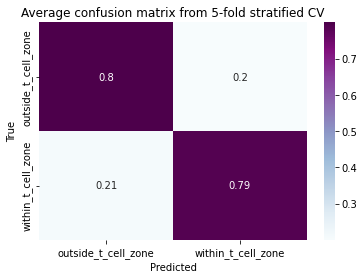

In [30]:
cplt = plot_cv_conf_mtx(
    X=filtered_nuc_feat,
    y=sample_labels,
    model=rfc,
    cv=n_folds,
    figsize=[6, 4],
)

In [31]:
## Fiting the model on the training data
fitted_rfc = rfc.fit(X=filtered_nuc_feat, y=sample_labels)
cPickle.dump(fitted_rfc,open( output_dir + 'rf_classifier', 'wb')) #save the classifier
## get prediction probabilities for each nucleus in the training dataset
pred = pd.DataFrame(fitted_rfc.predict(X=filtered_nuc_feat),
                    columns = ["predicted_class"],index=filtered_nuc_feat.index)
pred["actual_stage"] = sample_labels.astype(str)

pred_probs = pd.DataFrame(rfc.predict_proba(X=filtered_nuc_feat),
                          columns=["prob_" + x for x in list(rfc.classes_)],
                          index=filtered_nuc_feat.index,)
train_pred = pred.join(pred_probs)
train_pred['split'] = "train"

Now testing the performance on the test dataset

                     outside_t_cell_zone  within_t_cell_zone
outside_t_cell_zone                  366                 116
within_t_cell_zone                  3000               11710
                     precision    recall  f1-score   support

outside_t_cell_zone       0.11      0.76      0.19       482
 within_t_cell_zone       0.99      0.80      0.88     14710

           accuracy                           0.79     15192
          macro avg       0.55      0.78      0.54     15192
       weighted avg       0.96      0.79      0.86     15192



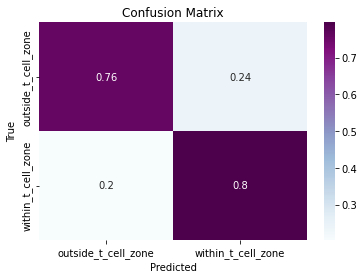

In [32]:
## get prediction probabilities for each nucleus
pred = pd.DataFrame(fitted_rfc.predict(X=test_data.loc[test_data.index, filtered_nuc_feat.columns]),
                    columns = ["predicted_class"],index=test_data.index)
pred["actual_stage"] =  test_data["stage"].astype(str)

pred_probs = pd.DataFrame(fitted_rfc.predict_proba(X=test_data.loc[test_data.index, filtered_nuc_feat.columns]),
                          columns=["prob_" + x for x in list(fitted_rfc.classes_)],
                          index=test_data.index)
test_pred = pred.join(pred_probs)
test_pred['split'] = "test"

## confusion matrix and perfromance metrics
conf_mtx = pd.DataFrame(confusion_matrix(test_pred["actual_stage"],
                                         test_pred["predicted_class"]), 
                    index=sorted(set(test_pred["actual_stage"])), 
                    columns=sorted(set(test_pred["actual_stage"])))
print(conf_mtx)

print(classification_report(test_pred["actual_stage"], 
                        test_pred["predicted_class"], 
                        target_names=sorted(set(test_pred["actual_stage"]))))

cplt = plot_conf_mtx(test_data.loc[:, filtered_nuc_feat.columns],
                    test_data["stage"].astype(str),
                    fitted_rfc,
                    normalize_matrix = "yes")   

In [33]:
# save the predictions
model_predictions = pd.concat([train_pred, test_pred])
model_predictions.to_csv(os.path.join( output_dir ,"model_predictions.csv"))

### Feature importance
Next we are interested in the features that yield the most discriminative power. To this end, we first look at the top 20 features that got the highest importance as computed by the RFC.

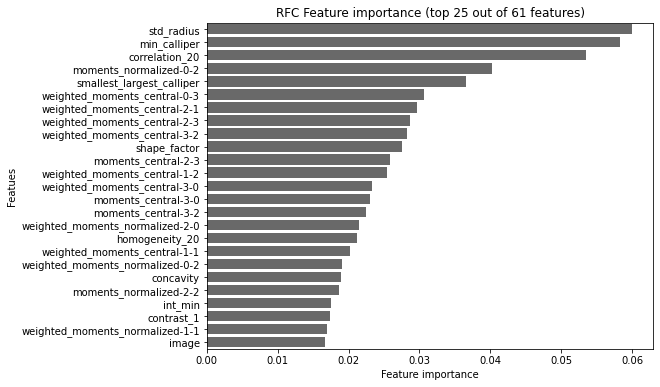

In [34]:
plot_feature_importance(
    importance=rfc.feature_importances_,
    names=filtered_nuc_feat.columns,
    model_type="RFC ",
    n_features=25
)

feat_import = pd.DataFrame(list(zip(training_data.columns, rfc.feature_importances_)),
                           columns=['feature','importance'])
feat_import.to_csv(os.path.join(output_dir ,"feature_importance.csv"))


As described earlier, we will additionally run a t-test based marker screen to identify the features that are the most different across the different stages.

In [35]:
marker_screen_results = find_markers(data=filtered_nuc_feat, labels=sample_labels)
marker_screen_results.to_csv(os.path.join( output_dir ,"marker_screen.csv"))

Run marker screen: 100%|██████████| 2/2 [00:00<00:00, 13.60it/s]


In [36]:
marker_screen_results.sort_values("fwer_padj").head(20)


,label,marker,fc,abs_delta_fc,pval,fwer_padj
2,outside_t_cell_zone,std_radius,1.480818,0.480818,3.514072e-122,4.287167e-120
2,within_t_cell_zone,std_radius,0.675302,0.324698,3.514072e-122,4.287167e-120
1,outside_t_cell_zone,smallest_largest_calliper,0.904832,0.095168,1.292096e-71,1.576357e-69
1,within_t_cell_zone,smallest_largest_calliper,1.105178,0.105178,1.292096e-71,1.576357e-69
23,outside_t_cell_zone,correlation_20,-0.384019,1.384019,1.721588e-45,2.100338e-43
23,within_t_cell_zone,correlation_20,-2.604041,3.604041,1.721588e-45,2.100338e-43
4,outside_t_cell_zone,shape_factor,1.050915,0.050915,3.345526e-45,4.081542e-43
4,within_t_cell_zone,shape_factor,0.951552,0.048448,3.345526e-45,4.081542e-43
11,outside_t_cell_zone,num_prominant_neg_curv,1.485162,0.485162,2.826751e-31,3.448636e-29
11,within_t_cell_zone,num_prominant_neg_curv,0.673327,0.326673,2.826751e-31,3.448636e-29


### Visualization

#### Reduced feature space
We now visualise the cells in the reduced feature space of the top 20 nmco features

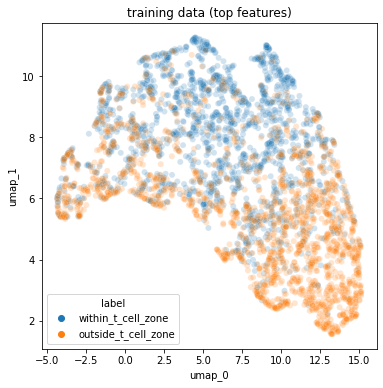

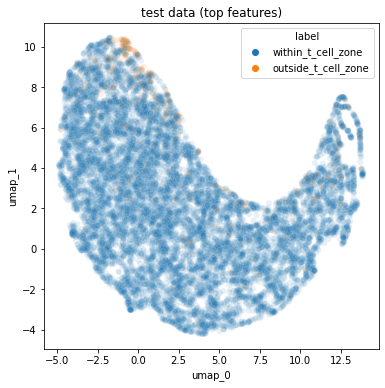

In [37]:
imp_features = feat_import[1:20].feature.tolist()

umpa_cord = plot_feature_space(data = gc_nuc_features.loc[training_data.index, imp_features],
                             labels = gc_nuc_features.loc[training_data.index, "stage"],
                             mode="umap",
                             figsize=[6, 6],
                             title="training data (top features)",
                             alpha=0.2)
umpb_cord = plot_feature_space(data = gc_nuc_features.loc[test_data.index, imp_features],
                             labels = gc_nuc_features.loc[test_data.index, "stage"],
                             mode="umap",
                             figsize=[6, 6],
                             title="test data (top features)",
                             alpha=0.1)

#### Prediction performance
We now plot the actual class vs predicted class in spatial cordinates for each image

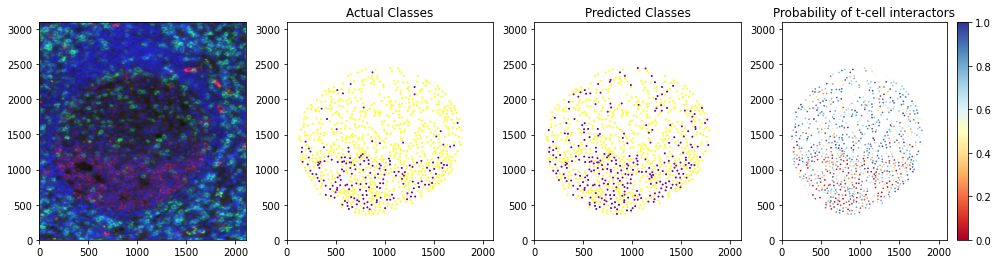

In [49]:
image_id = 5
img_path = os.path.join(os.path.join(path_to_raw_images,"images"),str(image_id)+".tif")

image = imread(img_path)
colors = {'within_t_cell_zone':'yellow', 'outside_t_cell_zone':'purple'}
grouped = gc_nuc_features.groupby(gc_nuc_features.image)
data = grouped.get_group(image_id)
x = spatial_cord.loc[data.index,'centroid-0']
y = spatial_cord.loc[data.index,'centroid-1']
pred_labels = model_predictions.loc[data.index,"predicted_class"]
act_labels = model_predictions.loc[data.index,"actual_stage"]
fig = plt.figure(figsize=(17, 4))
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

ax0.imshow(image,aspect='auto', origin ='lower') 
ax1.scatter(y,x, c=(act_labels.map(colors)),s=1)
ax1.set_title('Actual Classes')
ax1.set_ylim(0,image.shape[0])
ax1.set_xlim(0,image.shape[1])

ax2.scatter(y,x, c=(pred_labels.map(colors)),s=1)
ax2.set_title('Predicted Classes')
ax2.set_ylim(0,image.shape[0])
ax2.set_xlim(0,image.shape[1])
img = ax3.scatter(y,x, c=(model_predictions.loc[data.index,"prob_within_t_cell_zone"]),
                     s=0.5,cmap='RdYlBu',
                    vmin=0, vmax=1)
ax3.set_title('Probability of t-cell interactors')
ax3.set_ylim(0,image.shape[0])
ax3.set_xlim(0,image.shape[1])
plt.colorbar(img)

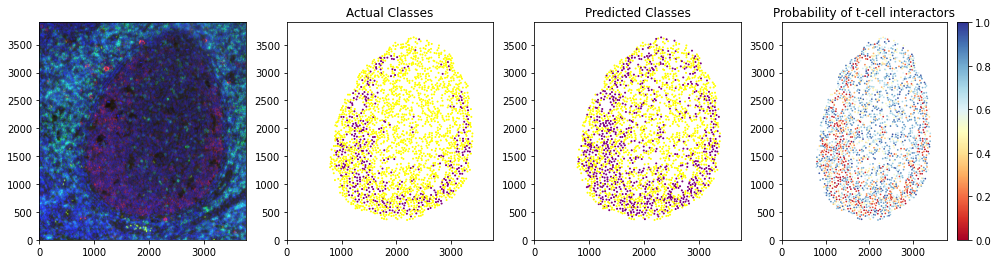

In [52]:
image_id = 3
img_path = os.path.join(os.path.join(path_to_raw_images,"images"),str(image_id)+".tif")

image = imread(img_path)
colors = {'within_t_cell_zone':'yellow', 'outside_t_cell_zone':'purple'}
grouped = gc_nuc_features.groupby(gc_nuc_features.image)
data = grouped.get_group(image_id)
x = spatial_cord.loc[data.index,'centroid-0']
y = spatial_cord.loc[data.index,'centroid-1']
pred_labels = model_predictions.loc[data.index,"predicted_class"]
act_labels = model_predictions.loc[data.index,"actual_stage"]
fig = plt.figure(figsize=(17, 4))
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

ax0.imshow(image,aspect='auto', origin ='lower') 
ax1.scatter(y,x, c=(act_labels.map(colors)),s=1)
ax1.set_title('Actual Classes')
ax1.set_ylim(0,image.shape[0])
ax1.set_xlim(0,image.shape[1])

ax2.scatter(y,x, c=(pred_labels.map(colors)),s=1)
ax2.set_title('Predicted Classes')
ax2.set_ylim(0,image.shape[0])
ax2.set_xlim(0,image.shape[1])
img = ax3.scatter(y,x, c=(model_predictions.loc[data.index,"prob_within_t_cell_zone"]),
                     s=0.5,cmap='RdYlBu',
                    vmin=0, vmax=1)
ax3.set_title('Probability of t-cell interactors')
ax3.set_ylim(0,image.shape[0])
ax3.set_xlim(0,image.shape[1])
plt.colorbar(img)
